# Estimation Exercise: 

## Method of Simulated Moments Estimation with respy

In [28]:
import os
import math
import copy
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

import respy as rp
from respy.method_of_simulated_moments import _harmonize_input
from estimagic.logging.create_database import load_database
from estimagic.logging.read_database import read_last_iterations
from estimagic import minimize

## Configure MSM inputs

To configure the MSM criterion function for estimation, we need to define a number of inputs. 

### Model

In [3]:
model = "robinson_crusoe_basic"

In [4]:
params, options = rp.get_example_model(model, with_data=False)

In [5]:
msm_inputs = {}
msm_inputs["params"], msm_inputs["options"] = params, options

### Moment & Replacement Functions

In [6]:
# Functions
def calc_choice_frequencies(df):
    """Calculate choice frequencies"""
    return df.groupby("Period").Choice.value_counts(normalize=True).unstack()

def calc_wage_distribution(df):
    """Calculate wage distribution."""
    return df.groupby(["Period"])["Wage"].describe()[["mean", "std"]]

def replace_nans(df):
    """Replace missing values in data."""
    return df.fillna(0)

In [7]:
msm_inputs["calc_moments"] = {
    "choice_frequencies": calc_choice_frequencies,
    "wage_distribution" : calc_wage_distribution
}

msm_inputs["replace_nans"] = {"replace_nans": replace_nans}

### Empirical Moments

In [8]:
simulate = rp.get_simulate_func(params,options)
data_obs = simulate(params)

msm_inputs["empirical_moments"] = {
    "choice_frequencies": replace_nans(calc_choice_frequencies(data_obs)),
    "wage_distribution" : replace_nans(calc_wage_distribution(data_obs)),
}

### Weighting Matrix

In [9]:
def get_weighting_matrix(data, calc_moments, num_boot, sample_boot):
    """ Compute weighting matrix for estimation with MSM."""
    np.random.seed(123)

    # Turn calc_moments into list in case it's a dict or single function.
    calc_moments = _harmonize_input(calc_moments)

    index_base = data.index.get_level_values("Identifier").unique()

    moments_sample = list()
    for _ in range(num_boot):
        ids_boot = np.random.choice(index_base, sample_boot, replace=False)
        moments_boot = [func(data.loc[ids_boot, :]) for func in calc_moments]

        moments_boot = rp.get_flat_moments(moments_boot)

        moments_sample.append(moments_boot)

    moments_var = np.array(moments_sample).var(axis=0)
    weighting_matrix = np.diag(moments_var ** (-1))

    return np.nan_to_num(weighting_matrix)

In [10]:
simulate = rp.get_simulate_func(params,options)
data_obs = simulate(params)

msm_inputs["weighting_matrix"] = get_weighting_matrix(
    data=data_obs,
    calc_moments=msm_inputs["calc_moments"],
    num_boot=300,
    sample_boot=500
)

### Criterion Function

In [11]:
criterion_msm = rp.get_msm_func(**msm_inputs)

## Configure optimization

### Add bounds to parameters

In [12]:
params

value
category                name                          
delta                   delta                     0.95
wage_fishing            exp_fishing               0.10
nonpec_fishing          constant                 -1.00
nonpec_hammock          constant                  2.50
                        not_fishing_last_period  -1.00
shocks_sdcorr           sd_fishing                1.00
                        sd_hammock                1.00
                        corr_hammock_fishing     -0.20
lagged_choice_1_hammock constant                  1.00
inadmissibility_penalty inadmissibility_penalty -20.00

In [13]:
params["upper"] = [1, 0.2, 0, 3, 0, np.nan, np.nan, np.nan, np.nan, np.nan]
params["lower"] = [0, 0.05, -1.5, 2, -1.5, np.nan, np.nan, np.nan, np.nan, np.nan ]

In [14]:
params

value  upper  lower
category                name                                        
delta                   delta                     0.95    1.0   0.00
wage_fishing            exp_fishing               0.10    0.2   0.05
nonpec_fishing          constant                 -1.00    0.0  -1.50
nonpec_hammock          constant                  2.50    3.0   2.00
                        not_fishing_last_period  -1.00    0.0  -1.50
shocks_sdcorr           sd_fishing                1.00    NaN    NaN
                        sd_hammock                1.00    NaN    NaN
                        corr_hammock_fishing     -0.20    NaN    NaN
lagged_choice_1_hammock constant                  1.00    NaN    NaN
inadmissibility_penalty inadmissibility_penalty -20.00    NaN    NaN

### Create configuration dictionary for optimization

In [15]:
optim_config = {
    "algorithm": "nlopt_bobyqa",
    "constraints": rp.get_parameter_constraints(model)
    + [{"loc": "inadmissibility_penalty", "type": "fixed"}],
    "general_options": {"n_cores": 4},
}

### Logging

In [16]:
def create_logging_path(target_dir):
    """
    Creates a directory in the path names in target_dir based on current
    date and time.
    """
    cwd = os.path.abspath(os.getcwd())
    dir = cwd + target_dir
    if not os.path.exists(dir):
        os.mkdir(dir)
    time = datetime.now().strftime("%d.%m.%Y_%H-%M-%S")
    logging_path = dir + "/" + time
    os.mkdir(logging_path)
    return logging_path

### Estimation Exercise

In [24]:
logging_path = create_logging_path("/logging/")

In [25]:
def delta_exercise(
        params_true,
        criterion,
        optim_config,
        logging_path,
        eval_away,
        eval_back,
):
    """ 
    Estimation exercise to test the mechanics of the estimation proceidure. It comprises the following steps:
        1. Begin with the true parameter vector `params_true`, set delta to 0, and fix it in the constraints, 
        thereby misspecifying the model.
        2. Estimate the free parameters for the misspecified model for a selected number of maximum evaluations of
        the criterion function.
        3. Using the resulting parameter vector from (2) as start values, set delta back to it's true value 
        and estimate again.
    """
    configuration = copy.deepcopy(optim_config)

    # 1. Set delta to 0 & estimate parameters.
    start_away = params_true.copy()
    start_away.loc["delta", "value"] = 0
    
    configuration["constraints"] += [{"loc": "delta", "type": "fixed"}]
    configuration["algo_options"] = {"maxeval": eval_away}
    rslt_away = minimize(
        criterion,
        params=start_away,
        logging=logging_path + "/logging_away.db",
        **configuration
    )

    # 2. Set delta back to true value and estimate again.
    start_back = rslt_away[1][["value"]].copy()
    start_back.loc["delta", "value"] = params_true.loc[("delta","delta"), "value"]
    configuration["algo_options"] = {"maxeval": eval_back}

    rslt_back = minimize(
        criterion,
        params=start_back,
        logging=logging_path + "/logging_back.db",
        **configuration
    )

    # 3. Save results.
    params_dict = {"start_away_delta_zero": start_away,
                   "rslt_away": rslt_away[1],
                   "start_back_true_delta": start_back,
                   "rslt_back": rslt_back[1],
                   }
    params_final = _concat_params(params_true, params_dict)

    # Add items to dict for logging.
    configuration["algo_options_away"] = {"maxeval": eval_away}

    return params_final, params_dict, configuration


def _concat_params(params, params_dict):
    """ Concatenates parameters listed in params_dict to the pd.DataFrame
    params. Value column will be renamed to 'true' for the base parameter
    vector and to the key in in params_dict for the other vectors."""
    params = params.copy()
    params.rename(columns={"value":"true"}, inplace=True)

    for key in params_dict.keys():
        params[key] = params_dict[key]["value"]

    return params


In [29]:
params_final, params_dict, configuration = delta_exercise(
    params_true=params,
    criterion=criterion_msm,
    optim_config=optim_config,
    logging_path=logging_path,
    eval_away=500,
    eval_back=500,
)

### Show Results

In [30]:
def get_simulated_moments(msm_inputs, params_dict):
    """ Compute simulated moments based on inputs defined in msm_inputs."""
    simulate = rp.get_simulate_func(msm_inputs["params"], msm_inputs["options"])

    moments_dict = {}
    for func_key in msm_inputs["calc_moments"].keys():
        func = msm_inputs["calc_moments"][func_key]
        mom_dict ={}
        for key in params_dict.keys():
            data_sim = simulate(params_dict[key])
            moments_sim = func(data_sim)
            mom_dict[key] = moments_sim

        moments_dict[func_key] = mom_dict

    return moments_dict

In [31]:
simulated_moments = get_simulated_moments(
    msm_inputs=msm_inputs, params_dict=params_dict
)

In [32]:
def plot_moments(empirical_moments, simulated_moments):
    """Plot empirical and simulated moments."""
    moments = copy.deepcopy(simulated_moments)
    # Add empirical_moments to dictionary with simulated moments.
    for key in empirical_moments.keys():
        moments[key]["observed"] = empirical_moments[key]

    # Plot moments.
    for set in moments.keys():
        plt.figure(figsize=(12, 8))
        for idx, key in enumerate(moments[set].keys()):
            plt.subplot(math.ceil(len(moments[set].keys())/2),2,idx+1)
            plt.plot(moments[set][key])
            plt.tight_layout()
            plt.legend(moments[set][key].columns, loc="best")
            plt.title(key)

        plt.suptitle(set)
        plt.show()

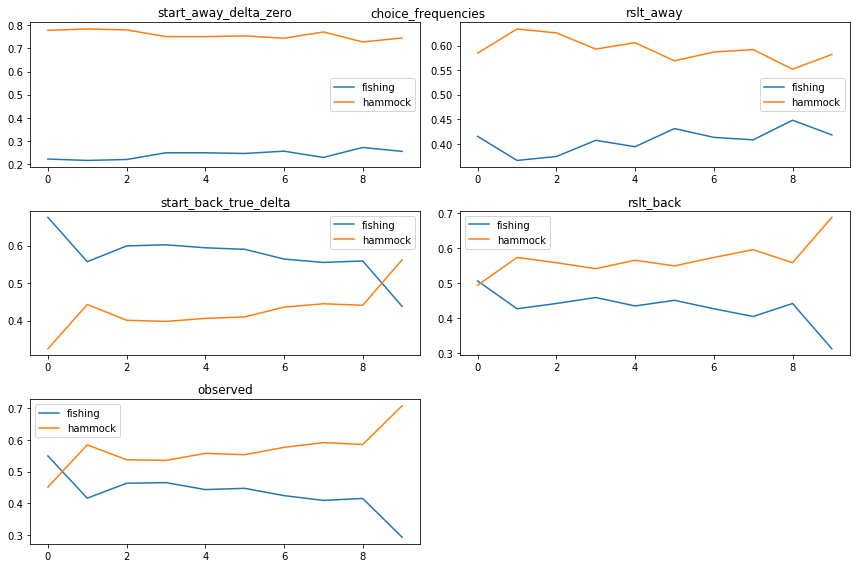

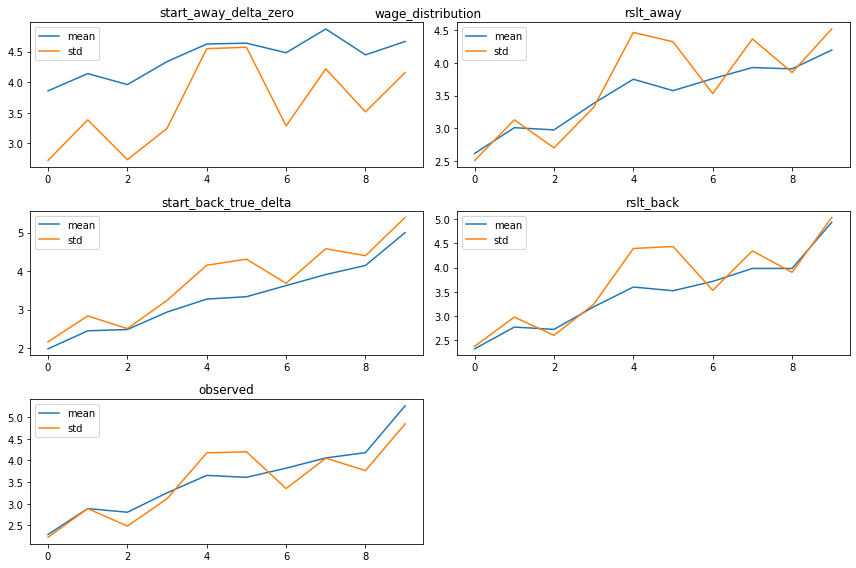

In [33]:
plot_moments(
    msm_inputs["empirical_moments"],
    simulated_moments=simulated_moments,
)

In [34]:
def plot_criterion_history(db_path, iterations):
    """Plot criterion history."""
    database = load_database(db_path)
    criterion_history = read_last_iterations(
        database, "criterion_history", iterations, "pandas")
    plt.plot(criterion_history, alpha=0.5)
    plt.title("Criterion History")
    plt.xlabel("Iterations")
    plt.ylabel("Criterion")
    plt.show()

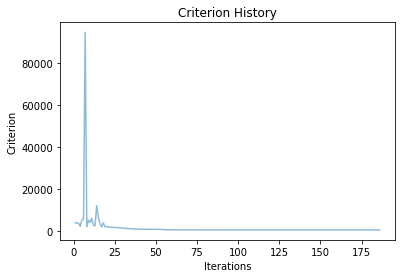

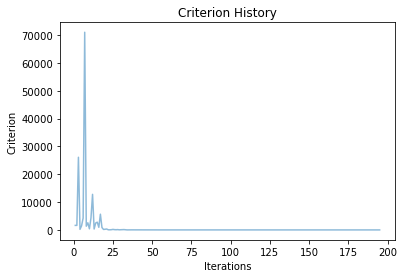

In [35]:
# Plot criterion history.
for db, evals in zip(["away", "back"], [10000, 10000]):
    plot_criterion_history(
        db_path=logging_path + "/logging_" + db + ".db",
        iterations=evals,
    )